### Part 1 ‑ Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
path="logins.json"
logins_raw=pd.read_json(path)
print(logins_raw.shape)
logins_raw.head()

(93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


*__Aggregate these login counts based on 15 minute time intervals__* [as requested in the challenge]

In [147]:
logins_raw["count"]=1
reset_df = logins_raw.set_index(['login_time'])
agg_15 = reset_df.resample('15T').sum()
print(agg_df.shape)
display(agg_15.head(2)) # 
agg_15.tail(2)

(9788, 1)


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6


,count
login_time,
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


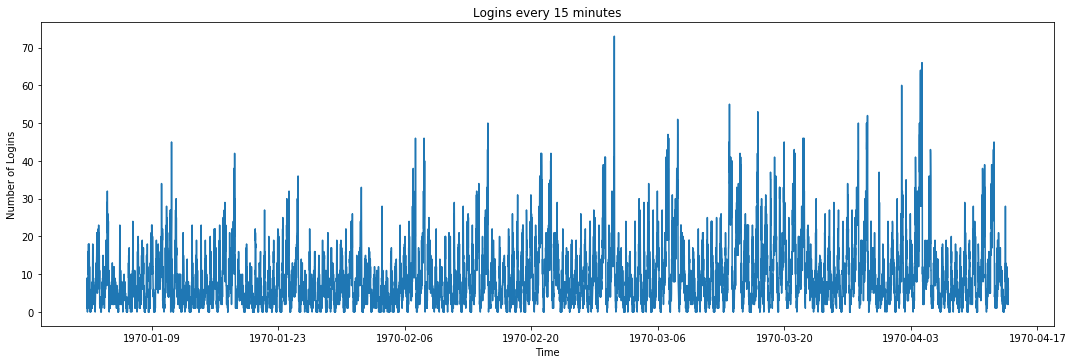

In [148]:
# plot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins every 15 minutes')
    
# puts the data in the figure
plt.plot(agg_15.index, agg_15["count"])

__Observation1__:<br>There doesn't seem to have a trend over time; but the figure is pretty jammed so it would be better to observe the time series data on other perspectives, such as:

- sum of daily visits for different days
- mean of the visits during each hour across all dates to find a specific hour with peak logins

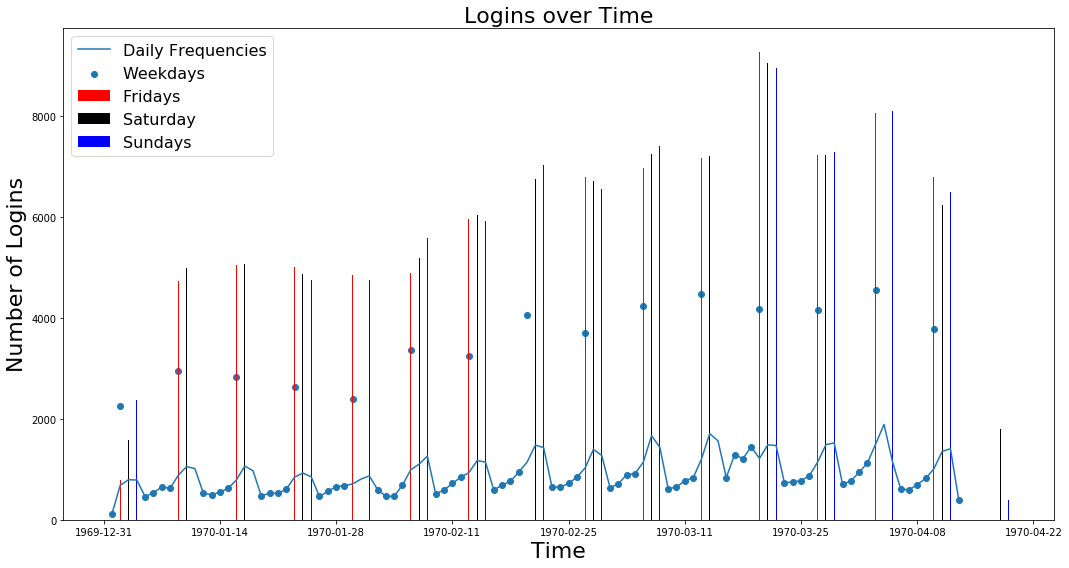

In [149]:
agg_daily=reset_df.resample('D').sum()
agg_biz = reset_df.resample('B').sum()
agg_fri = reset_df.resample('W-FRI').sum()
agg_sat = reset_df.resample('W-SAT').sum()
agg_sun = reset_df.resample('W-SUN').sum()

# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(agg_fri.index, agg_fri["count"], align= 'center', width = 0.1, label = "Fridays", color = 'R')
plt.bar(agg_sat.index, agg_sat["count"], label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(agg_sun.index, agg_sun["count"], label = "Sundays", align= 'center', width = 0.1, color = 'B')
plt.plot(agg_daily.index, agg_daily["count"], label = 'Daily Frequencies')
plt.scatter(agg_biz.index, agg_biz["count"], label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

__Observation2:__<br>
Fridays and weekends have dramatically higher logins compared to other days.

In [150]:
# resample index hourly
agg_hour = reset_df.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(agg_hour.index.dayofweek)
agg_hour['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
agg_hour['hour'] = [time.hour for time in agg_hour.index]

In [151]:
# create dataframe of the average number of logins for each hour of each day
day_map={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
avg_hour = pd.pivot_table(agg_hour, 
                          values = 'count', 
                          index = ['hour', 'day_of_week'],
                          aggfunc = np.mean)                       
avg_hour=avg_hour.reset_index()
avg_hour["day_of_week"]=avg_hour["day_of_week"].map(day_map)
avg_hour.head()

,hour,day_of_week,count
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


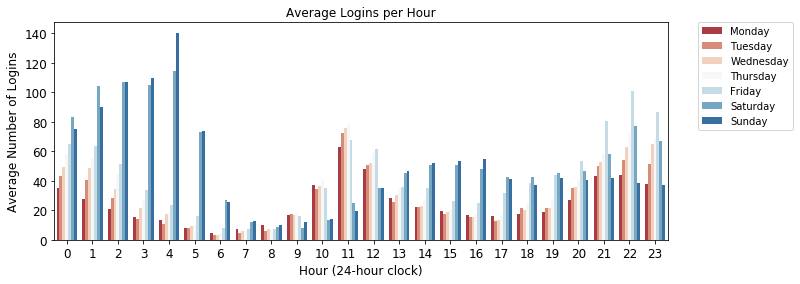

In [152]:
# plot the logins for 24 hours stratified by days of week
dims = (11, 4)
fig, ax = plt.subplots(figsize=dims)

sns.barplot(ax=ax, x = "hour", y = "count", hue = "day_of_week", data = avg_hour, palette = "RdBu")
ax.set_title('Average Logins per Hour', fontsize = 12)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 12)
ax.set_ylabel('Average Number of Logins', fontsize = 12)
ax.tick_params(labelsize=12,labelcolor="black")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

__Observation3:__<br>
The busiest hours are from 1am to 5am and the peak login value is 140 from 4-5 am on Sunday.

### Part 2 ‑ Experiment and metrics design

__Deeper Context – Why?__<br>
Before we design the metric, we need to know the reasons and context behind the goal. As in the description of this assignment, the city managers think that the passing fee might be a barrier for drivers to pick up passengers in the other city and *let’s first make some assumptions/clarifications based on this information:*
- The city managers care about making life more convenient/efficient for the citizens; they want to reduce the waiting time for the citizens
- The city managers also want the driver partners to benefit from the change because the driver partners can accept more passengers without the toll fee;
- The city managers don’t care about the finance for now (cancelling the toll is a short-time experiment and a small budget is allowed).

__Metric Design__<br>
Given the resources we know from the request, it can be assumed that the toll bridge has the records of crossing cars so that the number of cars can be easily obtained for each day, in the past as well as in the future.<br>
*__2 Key metrics –__*<br>
In order not to mix the effect on crossing the bridge to the two cities, I propose:
- The number of cars entering Metropolis during daytime hours for each weekday and the number of cars entering Gotham during the night for each weekday.<br>

*__Implementation of the experiment –__*
- Select a future week that has no special event (e.g., holidays, sports) for both cities and a past week similar to the future week in terms of month, special events, etc. (controlling for confounders)
- Collect data from the bridge recording system for those 2 weeks
- Apply hypothesis testing for the 2 metrics with 
 - Null hypothesis Ho: no difference in the number of passing cars before the change and after the change
 - Alternative Ha: there is an increase in passing cars after the change
- Use 2 sample t-test and generate a p-value with 95% confidence interval and effect size
- If the test is practically significant for both metrics, I would conclude that we can reject the null hypothesis and suggest the implementation of cancelling toll fee; if both metrics are not significant, then the conclusion is to not implement the change; if one metric is significant while the other is not, further investigation is needed.
<br>

*__Caveat to make use of number of crossing cars:__
- We also assume that other car owners would not change their driving route much after the change because their driving is part of their daily routine (e.g., from home to work and back); so we can assume the change, if there is any, purely comes from driver partners



### Part 3 ‑ Predictive modeling

### Step One - Data Wrangling & Feature Selection

In [3]:
# Import the dataset
path="/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/ultimate_challenge/ultimate_data_challenge.json"
with open(path) as f:
    data = json.load(f)
user_df=pd.DataFrame(data)
print(user_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


__Dealing with Missingness__<br>
There are missing cells for continuous variables and one categorical variable. 
- for continuous variables, just use imputation with mean since only small proportion of observations are missing;
- for categorical variables, just assign the missing cells as "missing" (a new class)

In [4]:
# Deal with missing cells
user_df["avg_rating_by_driver"].fillna(user_df["avg_rating_by_driver"].mean(),inplace=True)
user_df["avg_rating_of_driver"].fillna(user_df["avg_rating_of_driver"].mean(),inplace=True)
user_df["phone"]=user_df["phone"].replace(np.NaN,"missing")

__Create Target Variable__

In [5]:
# convert dates to datetime objects
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])

In [6]:
# create the target variable
# get the date 6 months later than the signup date
user_df["post_6m"]=user_df['signup_date']+pd.Timedelta('181D')
# get the date 30 days prior to last date of the 6th month
user_df["pre_30d"]=user_df['post_6m']-pd.Timedelta('30D')
# if last trip date apprears to be within the 6th month, 
# then the user is active
mask1 = user_df["last_trip_date"]<=user_df["post_6m"]
mask2 = user_df["pre_30d"]<=user_df["last_trip_date"]

In [7]:
user_df["mask"]=mask1.astype(int)+mask2.astype(int)
# user_df["active"]=user_df[user_df["mask1"]+user_df["mask2"]==2]
# user_df["active"]
def active(mask):
    if mask==2:
        return 1
    else:
        return 0
user_df["active"]=user_df["mask"].apply(active)
user_df["active"].value_counts()

0    37802
1    12198
Name: active, dtype: int64

In [56]:
fraction=user_df["active"].mean()
print("Fraction of Observations Retained is "+str(fraction))

Fraction of Observations Retained is 0.24396


<div class="alert alert-success">
__*24.4% of the users retained in their 6th month*__
</div>

__Get dummy features for categorical variables__

In [8]:
cat_cols=["city","phone","ultimate_black_user"]
for i in cat_cols:
    print("****************************")
    print(user_df[i].value_counts())
# transform categorical variable
df = pd.get_dummies(user_df, columns = cat_cols, drop_first=True)

****************************
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
****************************
iPhone     34582
Android    15022
missing      396
Name: phone, dtype: int64
****************************
False    31146
True     18854
Name: ultimate_black_user, dtype: int64


__Barplot to present difference of active percentages among different classes of categorical variables__

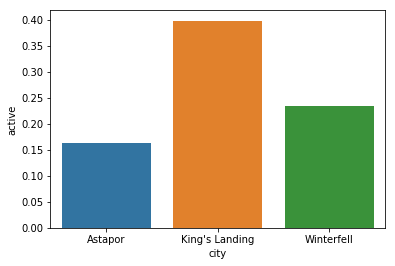

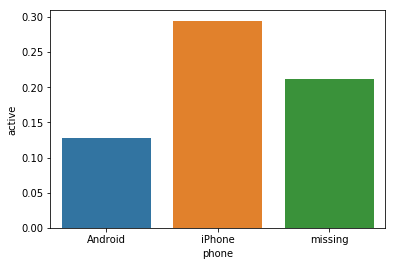

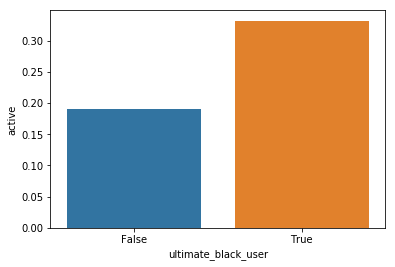

In [59]:
import seaborn as sns
def category_barplot(feature,target,df):
    f=df.groupby([feature])[target].mean()
    feature_df=pd.DataFrame(f)
    feature_df=feature_df.reset_index()
    g=sns.barplot(x=feature,y=target,data=feature_df)
    return plt.show()
category_barplot("city","active",user_df)
category_barplot("phone","active",user_df)
category_barplot("ultimate_black_user","active",user_df)

__Only keep features we need for further process__

In [23]:
dp_cols=['last_trip_date', 'signup_date', 
         'active', 'post_6m', 'pre_30d', "mask"]
df_x1 = df.drop(columns=dp_cols)
df_x1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone,phone_missing,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0,1,0,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,1,0,0,0


__Statistical Tests to Select Significant Features__

In [12]:
dummy_features=["city_King's Landing",'city_Winterfell', 'phone_iPhone', 
                'phone_missing', 'ultimate_black_user_True']
continuous_features=['avg_dist', 'avg_rating_by_driver', 
                     'avg_rating_of_driver', 'avg_surge','surge_pct', 
                     'trips_in_first_30_days','weekday_pct']

In [13]:
from statsmodels.stats.proportion import proportions_ztest

''' Include significant dummy variables using 2-sample z test '''
significant_features=[]
for i in dummy_features:
        n_pres_readm=df[df[i]==1]["active"].sum()
        n_abs_readm=df[df[i]==0]["active"].sum()
        n_presence=len(df[df[i]==1])
        n_absence=len(df[df[i]==0])
        
        count=np.array([n_pres_readm,n_abs_readm])
        obs=np.array([n_presence, n_absence])
        stat, pval=proportions_ztest(count, obs)
        if pval<0.05:
            significant_features.append(i)
            print(i+": "+str(round(pval,3)))

city_King's Landing: 0.0
city_Winterfell: 0.0
phone_iPhone: 0.0
ultimate_black_user_True: 0.0


In [14]:
''' Use p-values from logistic regression models '''
from statsmodels.discrete.discrete_model import Logit

y=np.array(df['active']).astype(float)
X=np.array(df[continuous_features]).astype(float)

In [15]:
import statsmodels.discrete.discrete_model as sm
from scipy import stats

stats.chisqprob = lambda chisq, df_v1: stats.chi2.sf(chisq, df_v1)

logit = sm.Logit(y, X)
results=logit.fit()
params=results.params

Optimization terminated successfully.
         Current function value: 0.534073
         Iterations 6


In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:                 0.03875
Time:                        22:33:58   Log-Likelihood:                -26704.
converged:                       True   LL-Null:                       -27780.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0344      0.002    -14.606      0.000      -0.039      -0.030
x2            -0.1194      0.018     -6.570      0.000      -0.155      -0.084
x3            -0.0579      0.016     -3.512      0.000      -0.090      -0.026
x4            -0.4008      0.073     -5.494      0.000      -0.544      -0.258
x5             0.0045      0.001      5.552      0.000       0.003       0.006
x6             0.1102      0.003     37.425      0.000       0.104       0.116
x7             0.0001      0.000      0.424      0.672      -0.000       0.001
==============================================================================
"""

In [17]:
continuous_significant=['avg_dist', 'avg_rating_by_driver', 
                     'avg_rating_of_driver', 'avg_surge','surge_pct', 
                     'trips_in_first_30_days']
features_s=significant_features+continuous_significant
df_v2=df[features_s]
len(features_s)

10

__Check for Colinearity__<br>
If VIF (variance inflation factor) is high, e.g., >10, then that variable probably should be dropped since it can be replaced by the linear combination of other variables

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_v2.values, i) 
                     for i in range(df_v2.shape[1])]
vif["features"] = df_v2.columns
vif

,VIF Factor,features
0,1.630105,city_King's Landing
1,2.403134,city_Winterfell
2,3.241439,phone_iPhone
3,1.659133,ultimate_black_user_True
4,2.116299,avg_dist
5,67.325463,avg_rating_by_driver
6,52.269962,avg_rating_of_driver
7,49.888528,avg_surge
8,2.831454,surge_pct
9,1.412932,trips_in_first_30_days


In [19]:
# 2 variables with high VIF; 
high_VIF_cols=["avg_rating_by_driver", "avg_rating_of_driver", "avg_surge"]
df_v3=df_v2.drop(columns=high_VIF_cols)
df_v4=df_v2.drop(columns=["avg_rating_of_driver","avg_surge"])

### Step Two - Machine Learning

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler,SMOTE

def train_pipe(df,clf,resample=False):

    X=df.as_matrix()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)

    sampler=RandomOverSampler
    if resample==True:
        ros = sampler(ratio='auto', random_state=25)
        X_train, y_train = ros.fit_sample(X_train, y_train) 
    

    clf=clf
    clf.fit(X_train,y_train)
    scores=cross_val_score(clf, X_train, y_train, cv=5,scoring='roc_auc')
    auc_score=roc_auc_score(y_test,clf.predict(X_test))
    report=classification_report(y_test,clf.predict(X_test))
    accuracy=accuracy_score(y_test,clf.predict(X_test))
    print(report)
    return accuracy, scores, auc_score

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
from sklearn.tree import DecisionTreeClassifier
''' First try a decision tree classifier '''

# Max depths=10 is the best parameters for test data 
clf1=DecisionTreeClassifier(max_depth=6,class_weight='balanced')
display(train_pipe(df_v2,clf1))
display(train_pipe(df_v3,clf1))

             precision    recall  f1-score   support

        0.0       0.89      0.75      0.81      9461
        1.0       0.47      0.72      0.57      3039

avg / total       0.79      0.74      0.75     12500



(0.73824,
 array([0.78169213, 0.79046476, 0.78707384, 0.79365459, 0.77970956]),
 0.7310354184663255)

             precision    recall  f1-score   support

        0.0       0.87      0.77      0.82      9461
        1.0       0.48      0.64      0.55      3039

avg / total       0.78      0.74      0.75     12500



(0.7424,
 array([0.76909883, 0.76585305, 0.77109714, 0.76981143, 0.76437468]),
 0.7085440275258965)

In [68]:
''' Try RandomForest to reduce over-fitting '''
from sklearn.ensemble import RandomForestClassifier

clf2=RandomForestClassifier(max_depth=6,class_weight='balanced')
display(train_pipe(df_v2,clf2))

             precision    recall  f1-score   support

        0.0       0.90      0.72      0.80      9461
        1.0       0.47      0.75      0.57      3039

avg / total       0.79      0.73      0.75     12500



(0.7304,
 array([0.79054197, 0.7989452 , 0.79696225, 0.80742087, 0.79308073]),
 0.736130754686486)

In [110]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
 'max_depth': [5, 10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [600, 800, 1000, 2000]}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
def randCV_RF(rf_base, random_grid):
    X=df_v2.as_matrix()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)    
    
    rf_clf=rf_base
    gsearch = RandomizedSearchCV(estimator = rf_clf, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = 3, verbose=0, 
                                  random_state=42, n_jobs = -1, 
                                  scoring='roc_auc')
    gsearch.fit(X_train,y_train)
    return gsearch.best_params_, gsearch.best_score_

In [111]:
rf_base=RandomForestClassifier()
randCV_RF(rf_base, random_grid)

({'n_estimators': 1000,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 'sqrt',
  'max_depth': 10,
  'bootstrap': True},
 0.8500236334421443)

In [27]:
rf_best=RandomForestClassifier(n_estimators=1000,
                            min_samples_split=10,
                            min_samples_leaf=4,
                            max_features='sqrt',
                            max_depth=10,
                            bootstrap=True)
train_pipe(df_v2,rf_best)

             precision    recall  f1-score   support

        0.0       0.82      0.93      0.87      9461
        1.0       0.64      0.38      0.47      3039

avg / total       0.78      0.80      0.78     12500



(0.79712,
 array([0.80234763, 0.8112244 , 0.80971373, 0.8144281 , 0.80405234]),
 0.6541205389722912)

In [28]:
from sklearn.linear_model import LogisticRegression

clf3=LogisticRegression(class_weight="balanced")
display(train_pipe(df_v2,clf3))

             precision    recall  f1-score   support

        0.0       0.86      0.70      0.77      9461
        1.0       0.41      0.65      0.50      3039

avg / total       0.75      0.69      0.71     12500



(0.68736,
 array([0.73395092, 0.7355996 , 0.73540059, 0.72285934, 0.73034194]),
 0.6745294993433322)

In [42]:
''' Now try the Xgboost classifier '''
import xgboost as xgb
clf4 = xgb.XGBClassifier(max_depth=10,objective='binary:logistic',
                         silent = True,n_estimators=50)
display(train_pipe(df_v2,clf4,resample=True))

             precision    recall  f1-score   support

        0.0       0.88      0.78      0.83      9461
        1.0       0.49      0.67      0.57      3039

avg / total       0.79      0.75      0.76     12500



(0.75248,
 array([0.8655647 , 0.87292648, 0.88238073, 0.8817582 , 0.87875861]),
 0.725589115100564)

In [46]:
''' Tune the parameters of XgboostClassifier step by step '''
from sklearn.grid_search import GridSearchCV

def gridCV_Xgb(xgb_base, param_test):
    X=df_v2.as_matrix()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
     
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)    
    
    ros = RandomOverSampler(ratio='auto', random_state=25)
    X_train, y_train = ros.fit_sample(X_train, y_train) 
    
    xgb_clf=xgb_base
    gsearch1 = GridSearchCV(estimator = xgb_clf, 
                            param_grid = param_test, scoring='roc_auc', cv=5)
    gsearch1.fit(X_train,y_train)
    return gsearch1.best_params_, gsearch1.best_score_

In [47]:
param_test_1 = {
 'max_depth':[5,6,7],
 'min_child_weight':[3,4,5]
}
xgb_base_1=xgb.XGBClassifier(objective='binary:logistic',silent = True)

gridCV_Xgb(xgb_base_1, param_test_1)

({'max_depth': 7, 'min_child_weight': 3}, 0.8468864003462023)

In [48]:
xgb_clf_1=xgb.XGBClassifier(objective='binary:logistic',silent = True,
                      max_depth=7, min_child_weight=3)
train_pipe(df_v2,xgb_clf_1,resample=True)

             precision    recall  f1-score   support

        0.0       0.89      0.76      0.82      9461
        1.0       0.49      0.71      0.58      3039

avg / total       0.80      0.75      0.77     12500



(0.75264,
 array([0.83989196, 0.84680705, 0.84787205, 0.85117544, 0.84868673]),
 0.7396547208106963)

In [49]:
param_test_2 = {'gamma':[i/10.0 for i in range(0,5)]}
xgb_base_2=xgb_clf_1

gridCV_Xgb(xgb_base_2, param_test_2)

({'gamma': 0.0}, 0.8468864003462023)

In [52]:
xgb_clf_2=xgb.XGBClassifier(objective='binary:logistic',silent = True,
                      max_depth=7, min_child_weight=3,
                      gamma=0.0)
train_pipe(df_v2,xgb_clf_2,resample=True)

             precision    recall  f1-score   support

        0.0       0.89      0.76      0.82      9461
        1.0       0.49      0.71      0.58      3039

avg / total       0.80      0.75      0.77     12500



(0.75264,
 array([0.83989196, 0.84680705, 0.84787205, 0.85117544, 0.84868673]),
 0.7396547208106963)

In [53]:
param_test_3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
                }
xgb_base_3=xgb_clf_2

gridCV_Xgb(xgb_base_3, param_test_3)

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.8478140076824933)

In [65]:
xgb_clf_3=xgb.XGBClassifier(objective='binary:logistic',silent = True,
                      max_depth=7, min_child_weight=3,
                      gamma=0.0,subsample=0.9,colsample_bytree=0.7)
train_pipe(df_v2,xgb_clf_3,resample=True)

             precision    recall  f1-score   support

        0.0       0.89      0.76      0.82      9461
        1.0       0.49      0.72      0.59      3039

avg / total       0.80      0.75      0.77     12500



(0.75264,
 array([0.83987878, 0.84640201, 0.84727885, 0.85067476, 0.84897084]),
 0.7412182305781457)

In [66]:
param_test_4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgb_base_4=xgb_clf_3
gridCV_Xgb(xgb_base_4, param_test_4)

({'reg_alpha': 0.005}, 0.8467321273581907)

In [64]:
xgb_clf_4=xgb.XGBClassifier(objective='binary:logistic',silent = True,
                      learning_rate =0.1, n_estimators=50,
                      max_depth=7, min_child_weight=3,
                      gamma=0.0,subsample=0.9,colsample_bytree=0.7,
                      reg_alpha=0.005)
train_pipe(df_v2,xgb_clf_4,resample=True)

             precision    recall  f1-score   support

        0.0       0.90      0.76      0.82      9461
        1.0       0.49      0.73      0.59      3039

avg / total       0.80      0.75      0.76     12500



(0.75,
 array([0.83040743, 0.83665553, 0.83711102, 0.83959797, 0.83970976]),
 0.7421545313454772)

In [70]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = xgb_clf_4.feature_importances_
feature_importance = feature_importance.set_index(df_v2.columns)
feature_importance.coef

city_King's Landing         0.021694
city_Winterfell             0.028306
phone_iPhone                0.030992
ultimate_black_user_True    0.037603
avg_dist                    0.333264
avg_rating_by_driver        0.077893
avg_rating_of_driver        0.128512
avg_surge                   0.104752
surge_pct                   0.108264
trips_in_first_30_days      0.128719
Name: coef, dtype: float32

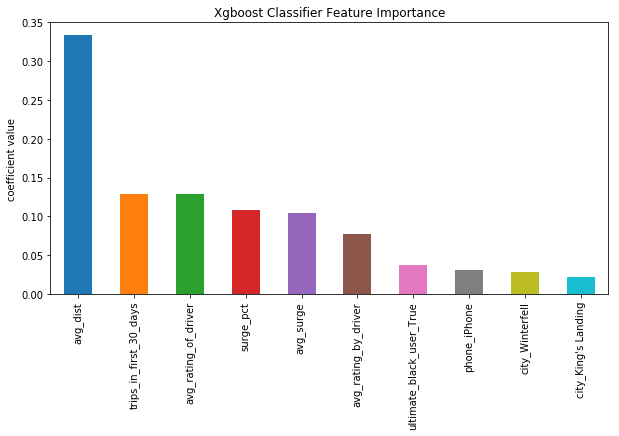

In [72]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef'].nlargest(10)).plot(kind='bar', x=feature_importance.index)
plt.title('Xgboost Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

#### Conclusion
For this project, the predicion model using Xgboost algorithm was developed with an accuracy of 0.75 and AUC of 0.74. Specifcly, random oversampling was applied to inflate the weight on target outcome of "1", so that the recall was better with a score of 0.73.<br>
Top important features were also identified. The average distance in miles per trip impacts the outcome the most. As the coefficient of this variable when checking the significance is negative, which means that riders with shorter trips have higher retention rates. Ultimate can target local residents more for their outcomes.